# Identifying 2D Ising Model Phases with Logistic Regression

In this notebook we use the binary classification method logistic regression to determine the phases of the two-dimensional Ising model.

### Configure notebook

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import pickle
import urllib

import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

# Import code from src
sys.path.insert(0, '../src/')
from logisticmodel import LogisticRegression
from project_tools import fig_path

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


### Ising model parameters

In [3]:
np.random.seed(42) # shuffle random seed generator

L = 40                          # linear system size
J = -1.0                        # Ising interaction
T = np.linspace(0.25, 4.0, 16)  # set of temperatures
T_c = 2.26                      # Onsager critical temperature in the TD limit

### Download data set

In [7]:
# Run this cell to load data from web. 
# Downloaded files will be stored locally, i.e. one run of this cell is enough
# Warning: data set is approx 2GB

url_main = "https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/"
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

labels = pickle.load(urllib.request.urlopen(url_main + label_file_name))

data = pickle.load(urllib.request.urlopen(url_main + data_file_name))
data = np.unpackbits(data).reshape(-1, 1600)
data = data.astype('int')

np.save("labels", labels)
np.save("spin_data", data)

del data, labels

### Load data set

In [4]:
X = np.load("spin_data.npy")
y = np.load("labels.npy")

# divide data into ordered, critical and disordered
X_ordered = X[:70000,:]
y_ordered = y[:70000]

X_critical = X[70000:100000,:]
y_critical = y[70000:100000]

X_disordered = X[100000:,:]
y_disordered = y[100000:]

# define training and test data sets
X = np.concatenate((X_ordered, X_disordered))
y = np.concatenate((y_ordered, y_disordered))

# create the training and test sets
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = logreg.split_data(X, y, test_ratio=0.96)

# full data set
X = np.concatenate((X_critical, X))
y = np.concatenate((y_critical, y))

print('X_train shape:', X_train.shape)
print('Y_train shape:', y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

X_train shape: (5200, 1600)
Y_train shape: (5200,)

5200 train samples
30000 critical samples
124800 test samples


### Plot a few Ising states

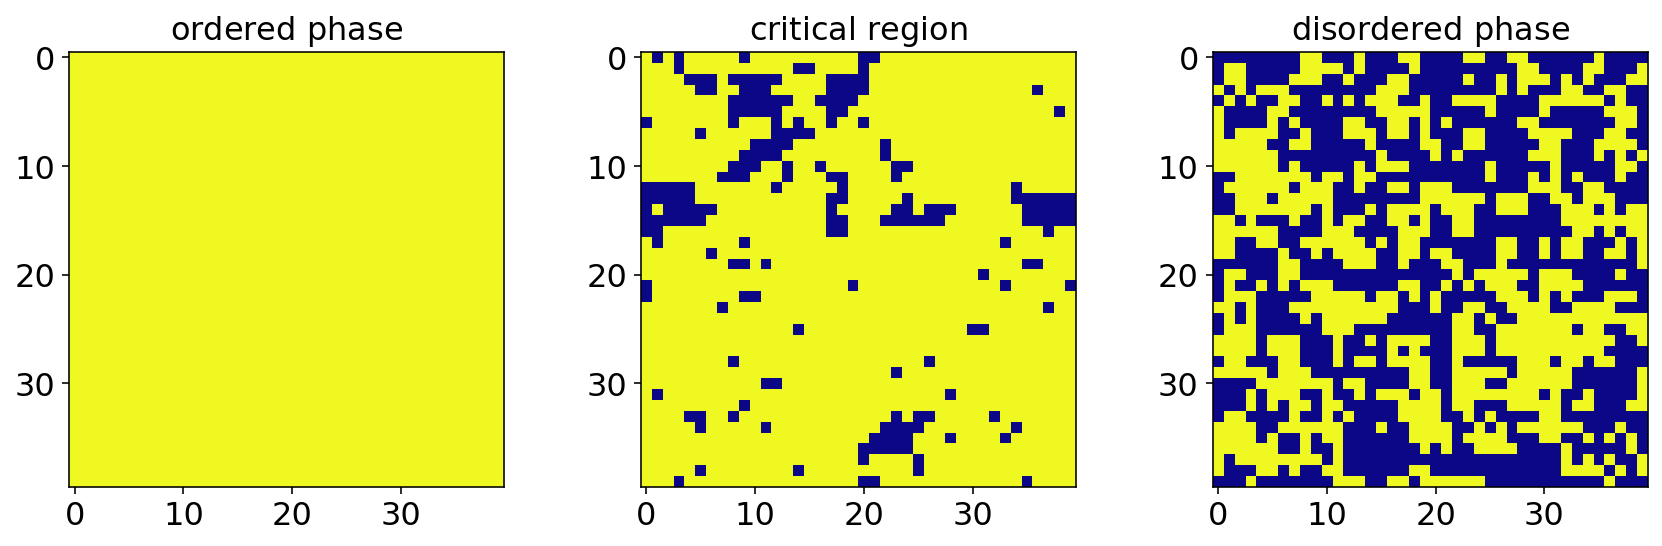

In [5]:
# set colourbar map
cmap_args = dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[20001].reshape(L, L), **cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$', fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[10001].reshape(L, L), **cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ region}$', fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[50001].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)
fig.savefig(fig_path("ising_2d_states.pdf"), bbox_inches='tight')
plt.show()

## Identify phases

In [5]:
# fit training data
logreg = LogisticRegression(n_iter=10)
logreg.fit(X_train, y_train)

# check accuracy
train_accuracy = logreg.accuracy(X_train, y_train)
test_accuracy = logreg.accuracy(X_test, y_test)
critical_accuracy = logreg.accuracy(X_critical, y_critical)

print('accuracy: train, test, critical')
print('GD: %0.4f, %0.4f, %0.4f' %(train_accuracy, test_accuracy, critical_accuracy))

logreg.fit(X_train, y_train, method='NR', verbose=True)

# check accuracy
train_accuracy = logreg.accuracy(X_train, y_train)
test_accuracy = logreg.accuracy(X_test, y_test)
critical_accuracy = logreg.accuracy(X_critical, y_critical)
print('NR: %0.4f, %0.4f, %0.4f' %(train_accuracy, test_accuracy, critical_accuracy))

accuracy: train, test, critical
GD: 65.0000, 64.8454, 33.3333
Initial weights: [0. 0. 0. ... 0. 0. 0.]
Iteration no: 0
New beta: [ 1.0822665  -0.00959159  0.280615   ... -0.5054602  -0.04490254
 -0.04003564]
Log likelihood: -2072.434170140541
L2 change 9.282136259381602
Iteration no: 1
New beta: [ 1.55830564 -0.0434027   0.61985992 ... -1.12591211  0.01663899
 -0.14102939]
Log likelihood: -1560.0428946185484
L2 change 9.278986516637666
Iteration no: 2
New beta: [ 2.14102944 -0.30983501  1.3589014  ... -2.52711887  0.16238755
 -0.1870768 ]
Log likelihood: -1130.2473903039927
L2 change 16.620159694863197
Iteration no: 3
New beta: [ 2.94687054 -0.40577927  2.28644631 ... -4.50177596  0.2633935
 -0.09575877]
Log likelihood: -839.8411053589734
L2 change 25.099986545363617
Iteration no: 4
New beta: [ 3.97217768 -0.81814506  4.08741749 ... -6.69395568  0.83762182
 -0.01539743]
Log likelihood: -767.3899584236715
L2 change 30.41289382215998
Iteration no: 5
New beta: [  5.3057722   -1.44663141  